In [1]:
import os
import scipy as sp
import random
from torch import nn
from torch import optim
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import numpy as np
from src.utils import TrainerConfig
from src.training.training import Trainer
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import r2_score
from src.net import CuiNet
from src.net import CuiNet_dp
from src.net.SWAG import SWAG

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)


2025-05-09 16:50:44.130388: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


dict_keys(['__header__', '__version__', '__globals__', 'DM_cal', 'DM_test', 'Sp_cal', 'Sp_test', 'wave', 'SP_all_test', 'SP_all_train'])


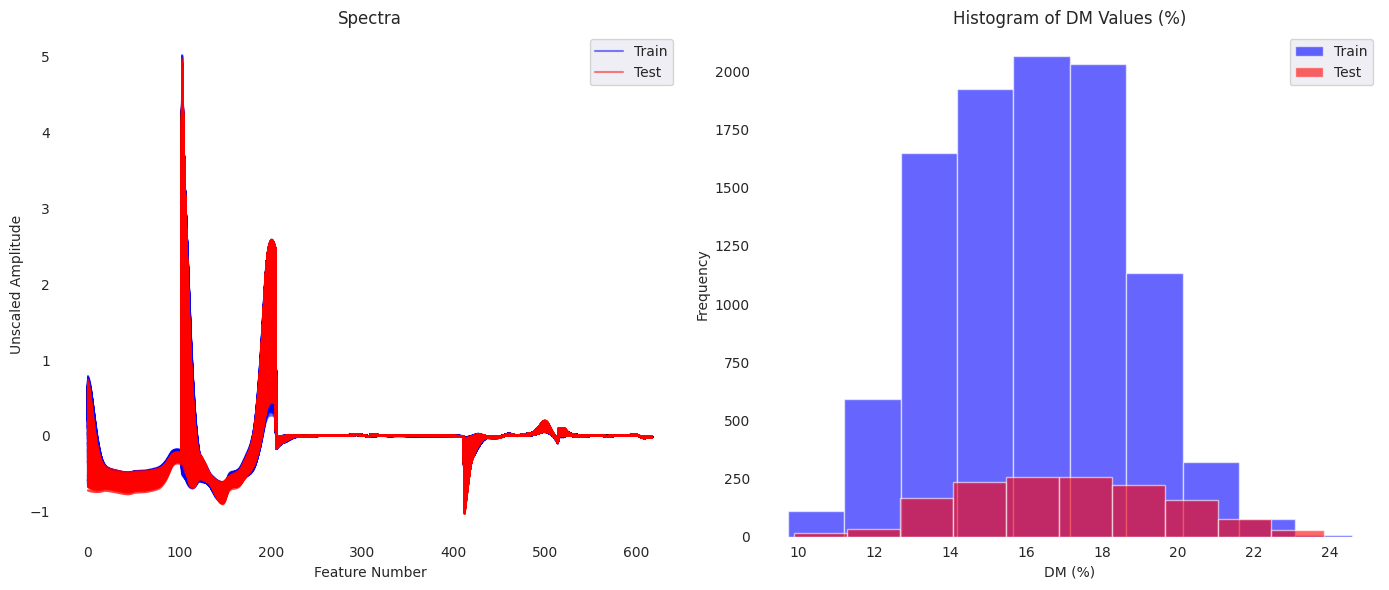

In [2]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = sp.io.loadmat("../data/dataset/Mango/mango_dm_full_outlier_removed2.mat")
print(data.keys())

Ycal = data["DM_cal"]
Ytest = data["DM_test"]
Xcal = data["SP_all_train"]
Xtest = data["SP_all_test"]


fig, axs = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')

# --- Spectra plot ---
axs[0].set_facecolor('white')
for spectrum in Xcal:
    axs[0].plot(spectrum, color='blue', alpha=0.5, label='Train' if 'Train' not in axs[0].get_legend_handles_labels()[1] else "")
for spectrum in Xtest:
    axs[0].plot(spectrum, color='red', alpha=0.5, label='Test' if 'Test' not in axs[0].get_legend_handles_labels()[1] else "")
axs[0].set_title('Spectra')
axs[0].set_xlabel('Feature Number')
axs[0].set_ylabel('Unscaled Amplitude')
axs[0].legend()

# --- Histogram of DM values ---
axs[1].set_facecolor('white')
axs[1].hist(Ycal, bins=10, color='blue', alpha=0.6, label='Train')
axs[1].hist(Ytest, bins=10, color='red', alpha=0.6, label='Test')
axs[1].set_title('Histogram of DM Values (%)')
axs[1].set_xlabel('DM (%)')
axs[1].set_ylabel('Frequency')
axs[1].legend()

plt.tight_layout()

In [3]:
plt.savefig("figure/spectra_and_Y.pdf", dpi=500, facecolor='white')
plt.show()

<Figure size 640x480 with 0 Axes>

In [4]:

## Spliting the train set
x_cal, x_val, y_cal, y_val = train_test_split(Xcal, Ycal, test_size=0.20, shuffle=True, random_state=42)

## The wavelenghts for the XX axis when we plot the spectra
x_scale = data['wave'].astype(np.float32).reshape(-1, 1)

# calculate mean and std per column

mean = np.mean(x_cal, axis=0)
std = np.std(x_cal, axis=0)

cal = data_utils.TensorDataset(torch.Tensor(x_cal), torch.Tensor(y_cal))
val = data_utils.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
test_dt = data_utils.TensorDataset(torch.Tensor(Xtest), torch.Tensor(Ytest))


In [5]:
model_name = "CuiNet_Mango_uncertainty"
p = 0.02

model = CuiNet(mean=mean, std=std, out_dims=1, input_dims=x_cal.shape[1], dropout=p)

config = TrainerConfig(model_name=model_name)
config.update_config(batch_size=128,learning_rate=0.002 ,num_epochs=500,save_model=True,classification=False,max_loss_plot=20)

model = CuiNet(mean=mean, std=std, out_dims=1, input_dims=x_cal.shape[1], dropout=p)
data_path = "data/dataset/Mango/mango_dm_full_outlier_removed2.mat"
save_path = os.path.dirname(os.path.abspath(data_path)) + f'/models/{model_name}/' + model_name
print(save_path)

cal_loader = data_utils.DataLoader(cal, batch_size=config.batch_size, shuffle=True)
val_loader = data_utils.DataLoader(val, batch_size=config.batch_size, shuffle=False)
test_loader = data_utils.DataLoader(test_dt, batch_size=config.batch_size, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=.015)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=25, factor=0.5, min_lr=1e-6,
                                                       verbose=True)
criterion = nn.MSELoss(reduction='none')
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")


/home/metz/deepchemometrics/Aioly/notebook/data/dataset/Mango/models/CuiNet_Mango_uncertainty/CuiNet_Mango_uncertainty
CuiNet(
  (dropout): ManualDropout()
  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=614, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=1, bias=True)
)
Number of parameters: 23053


Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_uncertainty_best.pth
Epoch 1/500 | Train Loss: 106.5182 | Val Loss: 6.2914 | Val Mean Metrics: 0.3380
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_uncertainty_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_uncertainty_best.pth
Epoch 2/500 | Train Loss: 10.2131 | Val Loss: 4.2978 | Val Mean Metrics: 0.3743
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_uncertainty_best.pth
Epoch 3/500 | Train Loss: 6.5421 | Val Loss: 3.1820 | Val Mean Metrics: 0.4164
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_uncertainty_best.pth
Epoch 4/500 | Train Loss: 5.5727 | Val Loss: 2.6776 | Val Mean Metrics: 0.4872
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNet_Mango_uncertainty_best.pth
Epoch 5/500 | Train Loss: 4.5004 | Val Loss: 2.2119 | Val Mean Metrics: 0.5767
M

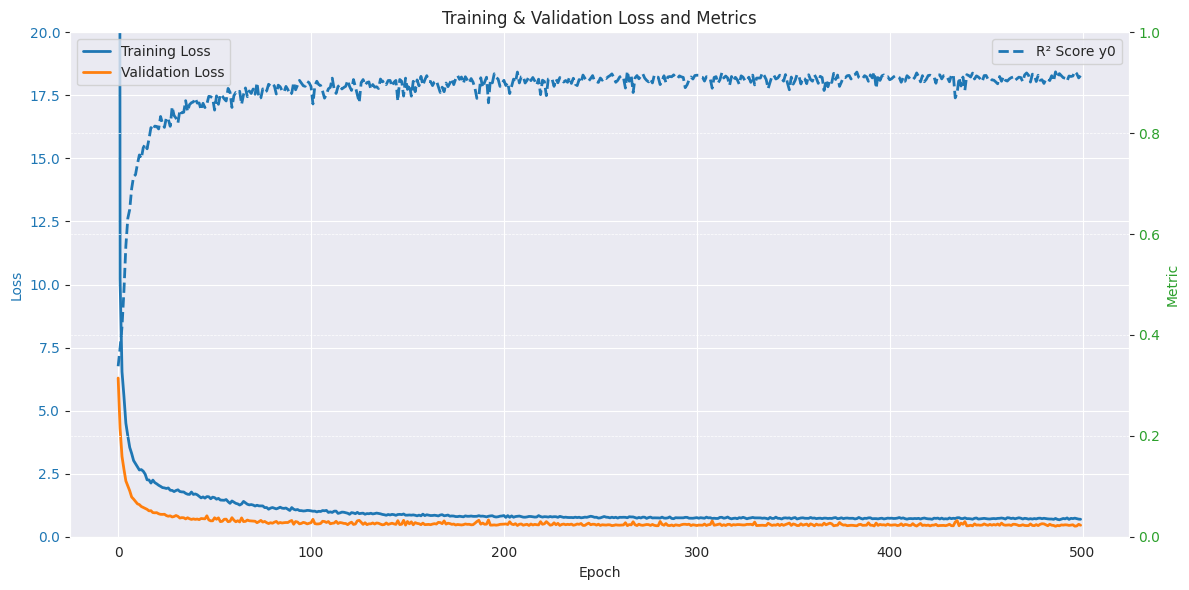

In [6]:
trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)
train_losses, val_losses, val_r2_scores, final_path1 = trainer.train()

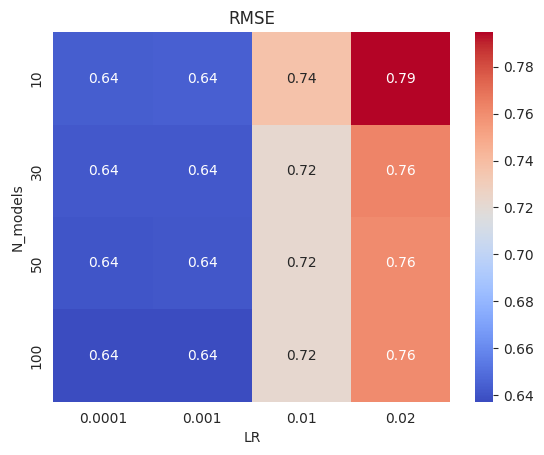

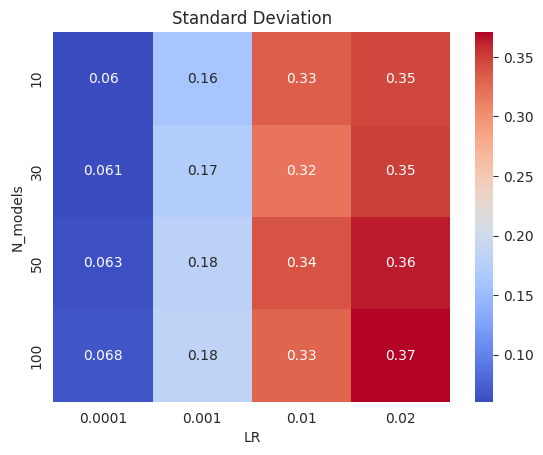

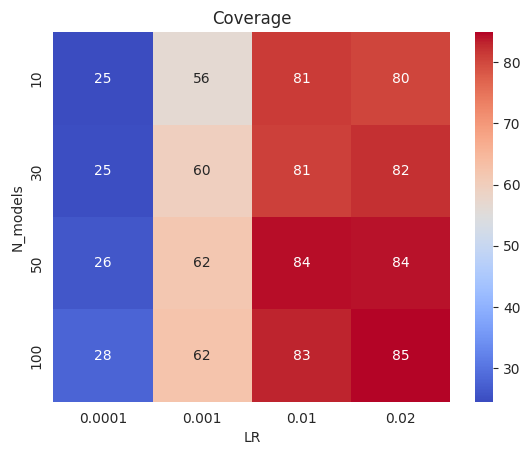

In [7]:
#### averaging strategies

# Best model charging
model.load_state_dict(torch.load(final_path1))
model.eval()


# Définition des hyperparamètres pour la grille
N_models_list = [10, 30, 50, 100]  # Nombre de modèles
LR_list = [0.0001, 0.001, 0.01,0.02]  # Taux d'apprentissage

# Initialisation des résultats
mean_rmse = np.zeros((len(N_models_list), len(LR_list)))
mean_std = np.zeros((len(N_models_list), len(LR_list)))
mean_coverage = np.zeros((len(N_models_list), len(LR_list)))
# Boucle sur les hyperparamètres

for i, N_models in enumerate(N_models_list):
    for j, LR in enumerate(LR_list):
        set_seed(42)
        # Initialisation du modèle et de l'optimiseur
        model = CuiNet(mean=mean, std=std, out_dims=1, input_dims=x_cal.shape[1], dropout=p)
        model.load_state_dict(torch.load(final_path1))
        optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=.015)
        criterion = nn.MSELoss(reduction='mean')
        trainer_2nd = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)


        list_of_models = []
        deep_e_epochs = N_models
        for epoch in range(deep_e_epochs):
            model.to("cuda")
            train_res = trainer_2nd.train_one_epoch()
            list_of_models.append(copy.deepcopy(model.to("cpu")))

        predictions = np.zeros((len(val_loader.dataset), N_models))
        targets = np.zeros((len(val_loader.dataset), 1))

        for k, model in enumerate(list_of_models[:N_models]):
            model.to("cuda")
            model.eval()

            idx = 0
            for input, target in val_loader:
                input = input.cuda(non_blocking=True)
                target = target.float()
                with torch.no_grad():
                    output = model(input[:, None])
                    predictions[idx: idx + input.size(0), k] = output.cpu().numpy().squeeze()
                targets[idx: idx + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
                idx += input.size(0)

        mean_predictions = predictions.mean(axis=1)
        uncertainties = predictions.std(axis=1)
        rmse_finale = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
        # Score Z pour un intervalle de confiance à 95%
        # Calcul des intervalles de confiance (prédiction ± incertitude)
        lower_bound = mean_predictions - 3 * uncertainties
        upper_bound = mean_predictions + 3 * uncertainties

        # Vérification si la vraie valeur est à l'intérieur de l'intervalle
        covered = (targets[:, 0] >= lower_bound) & (targets[:, 0] <= upper_bound)
        # Calcul de la couverture
        coverage = covered.mean() * 100

        # Stockage des résultats
        mean_rmse[i, j] = rmse_finale
        mean_std[i, j] = uncertainties.mean()
        mean_coverage[i, j] = coverage

plt.figure(facecolor="white")
# Heatmap pour le RMSE moyen
sns.heatmap(mean_rmse, annot=True, xticklabels=LR_list, yticklabels=N_models_list, cmap="coolwarm")
plt.title("RMSE")
plt.ylabel("N_models")
plt.xlabel("LR")
plt.savefig("figure/stacking/heatmap_rmse.pdf",dpi=500)
plt.show()

plt.figure(facecolor="white")
# Heatmap pour l'écart-type moyen
sns.heatmap(mean_std, annot=True, xticklabels=LR_list, yticklabels=N_models_list, cmap="coolwarm")
plt.title("Standard Deviation")
plt.ylabel("N_models")
plt.xlabel("LR")
plt.savefig("figure/stacking/heatmap_std.pdf",dpi=500)
plt.show()
plt.figure(facecolor="white")
# Heatmap pour l'écart-type moyen
sns.heatmap(mean_coverage, annot=True, xticklabels=LR_list, yticklabels=N_models_list, cmap="coolwarm")
plt.title("Coverage")
plt.ylabel("N_models")
plt.xlabel("LR")
plt.savefig("figure/stacking/heatmap_coverage.pdf",dpi=500)
plt.show()



Coverage (95% interval): 75.48%


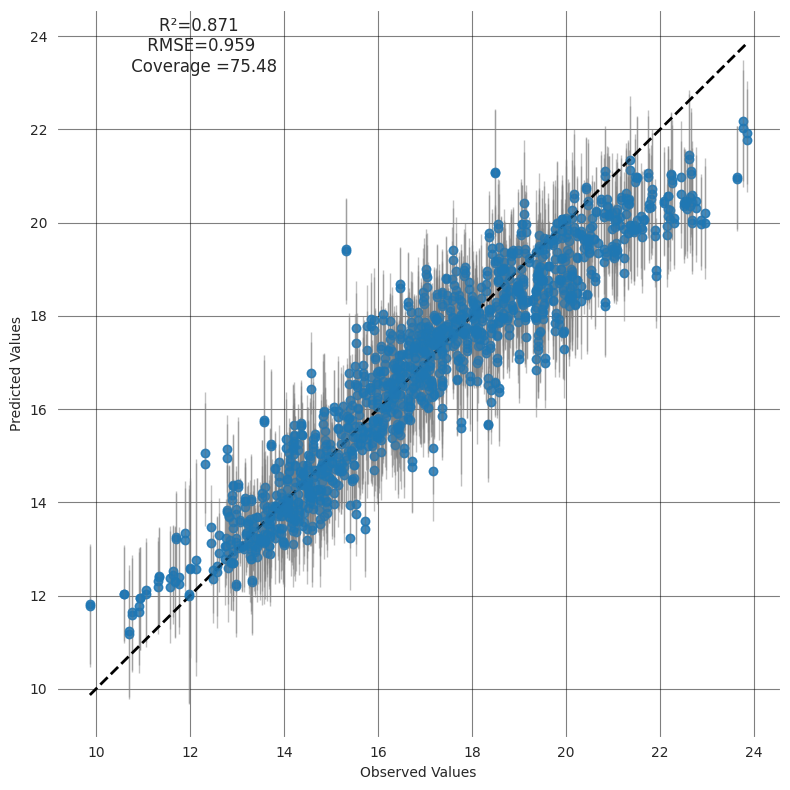

In [8]:
N_models = 50  # Nombre de modèles
LR = 0.01  # Taux d'apprentissage
z_score = 3

set_seed(42)
# Initialisation des résultats
mean_rmse = np.zeros((len(N_models_list), len(LR_list)))
mean_std = np.zeros((len(N_models_list), len(LR_list)))
mean_coverage = np.zeros((len(N_models_list), len(LR_list)))
# Boucle sur les hyperparamètres


set_seed(42)

# Initialisation du modèle et de l'optimiseur
model = CuiNet(mean=mean, std=std, out_dims=1, input_dims=x_cal.shape[1], dropout=p)
model.load_state_dict(torch.load(final_path1))
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=.015)
criterion = nn.MSELoss(reduction='mean')
trainer_2nd = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)


list_of_models = []
deep_e_epochs = N_models
for epoch in range(deep_e_epochs):
    model.to("cuda")
    train_res = trainer_2nd.train_one_epoch()
    list_of_models.append(copy.deepcopy(model.to("cpu")))

# Collecte des prédictions
predictions = np.zeros((len(test_loader.dataset), N_models))
targets = np.zeros((len(test_loader.dataset), 1))

for k, model in enumerate(list_of_models[:N_models]):
    model.to("cuda")
    model.eval()

    idx = 0
    for input, target in test_loader:
        input = input.cuda(non_blocking=True)
        target = target.float()
        with torch.no_grad():
            output = model(input[:, None])
            predictions[idx: idx + input.size(0), k] = output.cpu().numpy().squeeze()
        targets[idx: idx + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
        idx += input.size(0)

# Calcul des métriques
mean_predictions = predictions.mean(axis=1)
uncertainties = predictions.std(axis=1)
rmse_finale = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
r2 = r2_score(targets.squeeze(), mean_predictions)

# Score Z pour un intervalle de confiance à 95%
# Calcul des intervalles de confiance (prédiction ± incertitude)
lower_bound = mean_predictions - 3 * uncertainties
upper_bound = mean_predictions + 3 * uncertainties

# Vérification si la vraie valeur est à l'intérieur de l'intervalle
covered = (targets[:, 0] >= lower_bound) & (targets[:, 0] <= upper_bound)

# Calcul de la couverture
coverage = covered.mean()

# Affichage de la couverture en pourcentage
print(f"Coverage (95% interval): {coverage * 100:.2f}%")
# Visualisation : Scatter plot pour le meilleur RMSE moyen
fig, ax = plt.subplots(figsize=(8, 8))  # <-- changement ici pour récupérer fig, ax

# Scatter plot
ax.scatter(targets, mean_predictions, alpha=0.7)

# Texte (R², RMSE, Coverage)
ax.text(0.2, 0.95, f"R²={r2:.3f} \n RMSE={rmse_finale:.3f} \n Coverage ={coverage * 100:.2f}",
         ha='center', va='center', fontsize=12, transform=ax.transAxes)

# Barres d'erreur
ax.errorbar(
    targets.squeeze(),
    mean_predictions,
    yerr=uncertainties * 3,
    fmt='o',
    ecolor='gray',
    elinewidth=1,
    alpha=0.5,
    label="Uncertainty"
)

# Ligne y=x
ax.plot(
    [targets.min(), targets.max()],
    [targets.min(), targets.max()],
    'k--', lw=2,
    label="Perfect Prediction (y=x)"
)

# Labels
ax.set_xlabel("Observed Values")
ax.set_ylabel("Predicted Values")

# Grille noire
ax.grid(color='black', alpha=0.5)

# Fond du graphe en blanc
ax.set_facecolor('white')

# Fond de la figure en blanc
fig.patch.set_facecolor('white')

# Ajustement automatique
plt.tight_layout()

# Sauvegarde avec fond blanc
plt.savefig("figure/stacking/eval.pdf", dpi=500, facecolor='white')

# Affichage
plt.show()


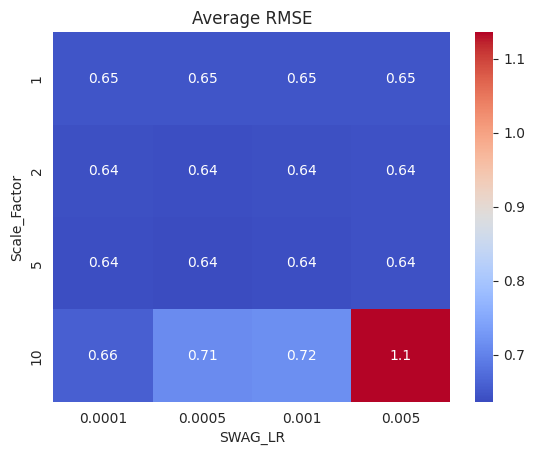

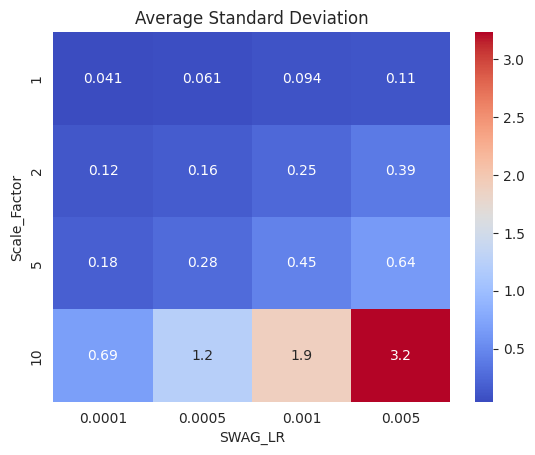

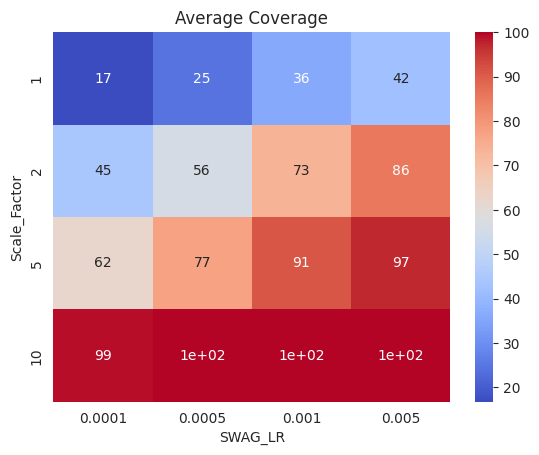

In [9]:
set_seed(42)
N = 100
num_epochs = 100

lr_swag_values = [0.0001, 0.0005, 0.001, 0.005]  # Différentes valeurs de learning rate pour SWAG
sample_values = [1, 2, 5, 10]  # Différentes valeurs pour swag_model.sample()
criterion = nn.MSELoss(reduction='mean')
# Initialisation des matrices pour stocker les résultats
mean_rmse = np.zeros((len(lr_swag_values), len(sample_values)))  # Matrice pour RMSE
mean_std = np.zeros((len(lr_swag_values), len(sample_values)))  # Matrice pour écart-type
mean_coverage = np.zeros((len(lr_swag_values), len(sample_values)))
# Test de différentes combinaisons de lr_swag et swag_model.sample()
for i, lr_swag in enumerate(lr_swag_values):

    # Charger le modèle et initialiser le modèle SWAG
    model = CuiNet(mean=mean, std=std, out_dims=1, input_dims=x_cal.shape[1], dropout=p)
    model.load_state_dict(torch.load(final_path1))
    model.to("cuda")


        # Réinitialisation de l'optimiseur
    config.update_config(learning_rate=lr_swag)

    optimizer = torch.optim.SGD(
        model.parameters(), lr=config.learning_rate
    )
    criterion = nn.MSELoss(reduction='mean')
    trainer_2nd = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)
    swag_model = SWAG(base=model, no_cov_mat=False).to("cuda")

    # Initialisation des variables pour collecter les résultats
    predictions = np.zeros((len(val_loader.dataset), N))  # Stockage des prédictions
    targets = np.zeros((len(val_loader.dataset), 1))

    # Boucle d'entraînement pour collecter les modèles SWAG et les mises à jour
    for epoch in range(num_epochs):  # Ici, on utilise 'epoch' comme nombre d'itérations


        train_res = trainer_2nd.train_one_epoch()


        # Collecter le modèle dans SWAG
        swag_model.collect_model(model)

    for j, sample_param in enumerate(sample_values):
        # Boucle pour obtenir les prédictions et les cibles
        for h in range(N):
            swag_model.sample(sample_param)  # Appliquer le paramètre sample
            swag_model.base.eval()

            k = 0

            for input, target in val_loader:
                input = input.cuda(non_blocking=True)
                target = target.float()
                with torch.no_grad():
                    output = swag_model(input[:, None])
                    predictions[k: k + input.size(0), h] = output.cpu().numpy().squeeze()
                targets[k: k + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
                k += input.size(0)

        mean_predictions = predictions.mean(axis=1)
        uncertainties = predictions.std(axis=1)
        rmse_finale = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
        # Score Z pour un intervalle de confiance à 95%
        # Calcul des intervalles de confiance (prédiction ± incertitude)
        lower_bound = mean_predictions - 3 * uncertainties
        upper_bound = mean_predictions + 3 * uncertainties

        # Vérification si la vraie valeur est à l'intérieur de l'intervalle
        covered = (targets[:, 0] >= lower_bound) & (targets[:, 0] <= upper_bound)
        # Calcul de la couverture
        coverage = covered.mean() * 100

        # Stockage des résultats
        mean_rmse[i, j] = rmse_finale
        mean_std[i, j] = uncertainties.mean()
        mean_coverage[i, j] = coverage

plt.figure(facecolor="white")
# Heatmap pour le RMSE moyen
sns.heatmap(mean_rmse, annot=True, xticklabels=lr_swag_values, yticklabels=sample_values, cmap="coolwarm")
plt.title("Average RMSE")
plt.xlabel("SWAG_LR")
plt.ylabel("Scale_Factor")
plt.savefig("figure/SWAG/mean_rmse.pdf", dpi=500)
plt.show()

plt.figure(facecolor="white")
# Heatmap pour l'écart-type moyen
sns.heatmap(mean_std, annot=True, xticklabels=lr_swag_values, yticklabels=sample_values, cmap="coolwarm")
plt.title("Average Standard Deviation")
plt.xlabel("SWAG_LR")
plt.ylabel("Scale_Factor")

plt.savefig("figure/SWAG/mean_std.pdf", dpi=500)
plt.show()
plt.figure(facecolor="white")
# Heatmap pour l'écart-type moyen
sns.heatmap(mean_coverage, annot=True, xticklabels=lr_swag_values, yticklabels=sample_values, cmap="coolwarm")
plt.title("Average Coverage")
plt.xlabel("SWAG_LR")
plt.ylabel("Scale_Factor")
plt.savefig("figure/SWAG/mean_coverage.pdf", dpi=500)
plt.show()


Coverage (95% interval): 100.00%


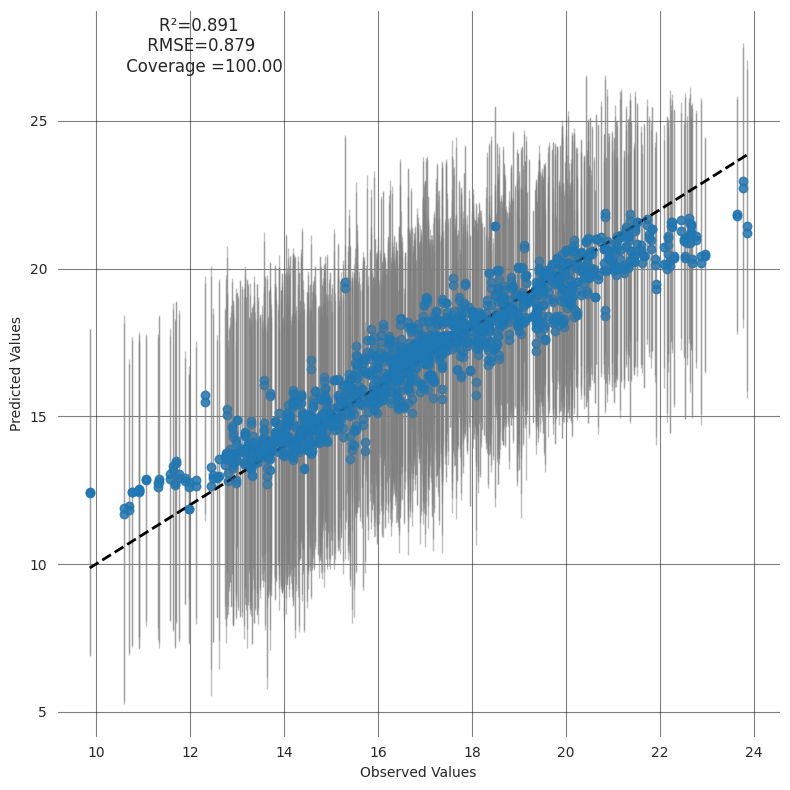

In [10]:
lr_swag_values = [0.005]  # Différentes valeurs de learning rate pour SWAG
sample_values = [5.]
N = 100

set_seed(42)
# Test de différentes combinaisons de lr_swag et swag_model.sample()


mean_rmse = np.zeros((len(lr_swag_values), len(sample_values)))  # Matrice pour RMSE
mean_std = np.zeros((len(lr_swag_values), len(sample_values)))  # Matrice pour écart-type
mean_coverage = np.zeros((len(lr_swag_values), len(sample_values)))
# Test de différentes combinaisons de lr_swag et swag_model.sample()
for i, lr_swag in enumerate(lr_swag_values):

    # Charger le modèle et initialiser le modèle SWAG
    model = CuiNet(mean=mean, std=std, out_dims=1, input_dims=x_cal.shape[1], dropout=p)
    model.load_state_dict(torch.load(final_path1))
    model.to("cuda")


        # Réinitialisation de l'optimiseur
    config.update_config(learning_rate=lr_swag)

    optimizer = torch.optim.SGD(
        model.parameters(), lr=config.learning_rate
    )
    criterion = nn.MSELoss(reduction='mean')
    trainer_2nd = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)
    swag_model = SWAG(base=model, no_cov_mat=False).to("cuda")

    # Initialisation des variables pour collecter les résultats
    predictions = np.zeros((len(test_loader.dataset), N))  # Stockage des prédictions
    targets = np.zeros((len(test_loader.dataset), 1))

    # Boucle d'entraînement pour collecter les modèles SWAG et les mises à jour
    for epoch in range(num_epochs):  # Ici, on utilise 'epoch' comme nombre d'itérations


        train_res = trainer_2nd.train_one_epoch()


        # Collecter le modèle dans SWAG
        swag_model.collect_model(model)

    for j, sample_param in enumerate(sample_values):
        # Boucle pour obtenir les prédictions et les cibles
        for h in range(N):
            swag_model.sample(sample_param)  # Appliquer le paramètre sample
            swag_model.base.eval()

            k = 0

            for input, target in test_loader:
                input = input.cuda(non_blocking=True)
                target = target.float()
                with torch.no_grad():
                    output = swag_model(input[:, None])
                    predictions[k: k + input.size(0), h] = output.cpu().numpy().squeeze()
                targets[k: k + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
                k += input.size(0)

# Calcul des métriques
mean_predictions = predictions.mean(axis=1)
uncertainties = predictions.std(axis=1)
rmse_finale = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
r2 = r2_score(targets.squeeze(), mean_predictions)

# Score Z pour un intervalle de confiance à 95%
# Calcul des intervalles de confiance (prédiction ± incertitude)
lower_bound = mean_predictions - 3 * uncertainties
upper_bound = mean_predictions + 3 * uncertainties

# Vérification si la vraie valeur est à l'intérieur de l'intervalle
covered = (targets[:, 0] >= lower_bound) & (targets[:, 0] <= upper_bound)

# Calcul de la couverture
coverage = covered.mean()

# Affichage de la couverture en pourcentage
print(f"Coverage (95% interval): {coverage * 100:.2f}%")
# Visualisation : Scatter plot pour le meilleur RMSE moyen
fig, ax = plt.subplots(figsize=(8, 8))  # <-- changement ici pour récupérer fig, ax

# Scatter plot
ax.scatter(targets, mean_predictions, alpha=0.7)

# Texte (R², RMSE, Coverage)
ax.text(0.2, 0.95, f"R²={r2:.3f} \n RMSE={rmse_finale:.3f} \n Coverage ={coverage * 100:.2f}",
         ha='center', va='center', fontsize=12, transform=ax.transAxes)

# Barres d'erreur
ax.errorbar(
    targets.squeeze(),
    mean_predictions,
    yerr=uncertainties * 3,
    fmt='o',
    ecolor='gray',
    elinewidth=1,
    alpha=0.5,
    label="Uncertainty"
)

# Ligne y=x
ax.plot(
    [targets.min(), targets.max()],
    [targets.min(), targets.max()],
    'k--', lw=2,
    label="Perfect Prediction (y=x)"
)

# Labels
ax.set_xlabel("Observed Values")
ax.set_ylabel("Predicted Values")

# Grille noire
ax.grid(color='black', alpha=0.5)

# Fond du graphe en blanc
ax.set_facecolor('white')

# Fond de la figure en blanc
fig.patch.set_facecolor('white')

# Ajustement automatique
plt.tight_layout()

plt.savefig("figure/SWAG/best_model.pdf",dpi = 500)
plt.show()




Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 68.1585 | Val Loss: 13.8900 | Val Mean Metrics: 0.1922
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 11.2045 | Val Loss: 9.1638 | Val Mean Metrics: 0.1947
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 6.8325 | Val Loss: 5.8490 | Val Mean Metrics: 0.3677
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 4.9704 | Val Loss: 4.1902 | Val Mean Metrics: 0.4635
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 4.1732 | Val Loss: 3.6392 | Val Mean Metrics: 0.4936
Model saved at epoch 4 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 6/500 

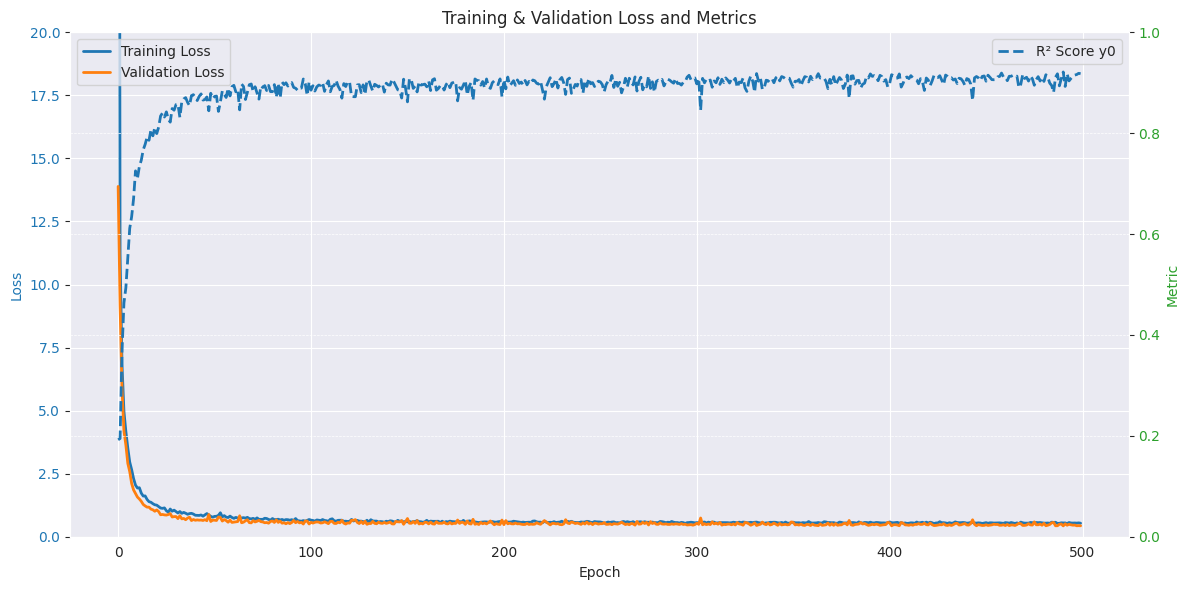

[0.17296647 0.29480625 0.29582606 ... 0.22708654 0.24644351 0.31162944]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 126.3028 | Val Loss: 21.9786 | Val Mean Metrics: 0.1251
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 15.3366 | Val Loss: 8.7749 | Val Mean Metrics: 0.2735
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 7.9675 | Val Loss: 5.2364 | Val Mean Metrics: 0.4087
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 5.8009 | Val Loss: 3.7390 | Val Mean Metrics: 0.5305
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 4.5579 | Val Loss: 2.9945 | Val Mean Metrics: 0.5766
Model saved at epoch 4 t

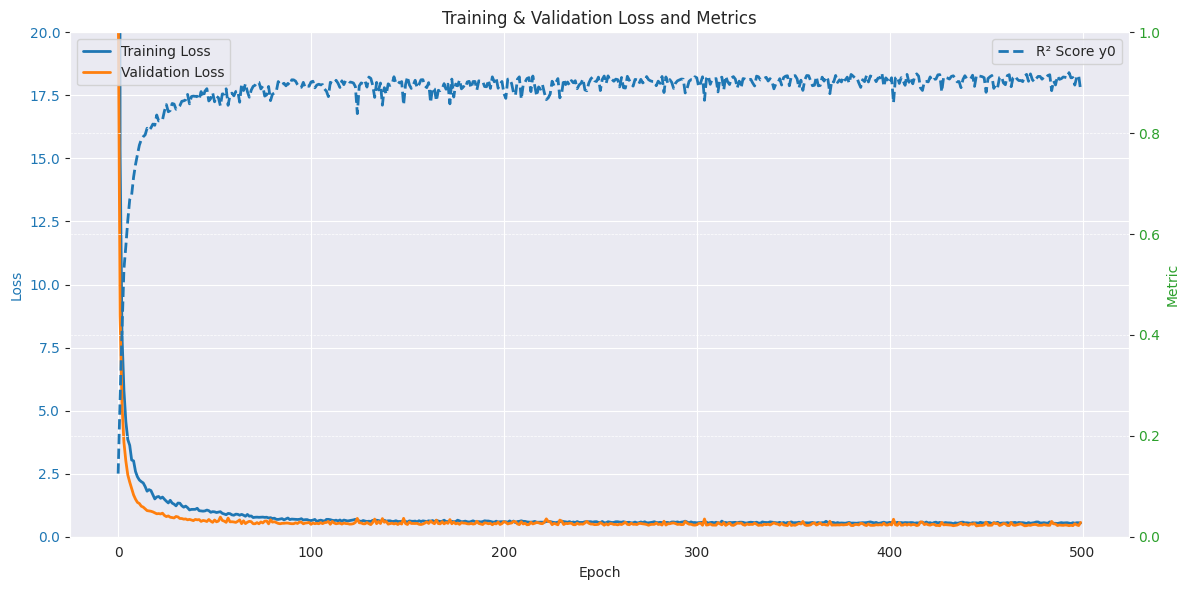

[0.3234103  0.29199418 0.42372922 ... 0.33952061 0.16386179 0.46400918]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 336.3540 | Val Loss: 45.5844 | Val Mean Metrics: -0.0255
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 54.8808 | Val Loss: 25.3742 | Val Mean Metrics: 0.0525
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 32.3949 | Val Loss: 17.6967 | Val Mean Metrics: 0.1326
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 21.7379 | Val Loss: 13.5860 | Val Mean Metrics: 0.1714
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 17.8528 | Val Loss: 10.4694 | Val Mean Metrics: 0.1939
Model saved at e

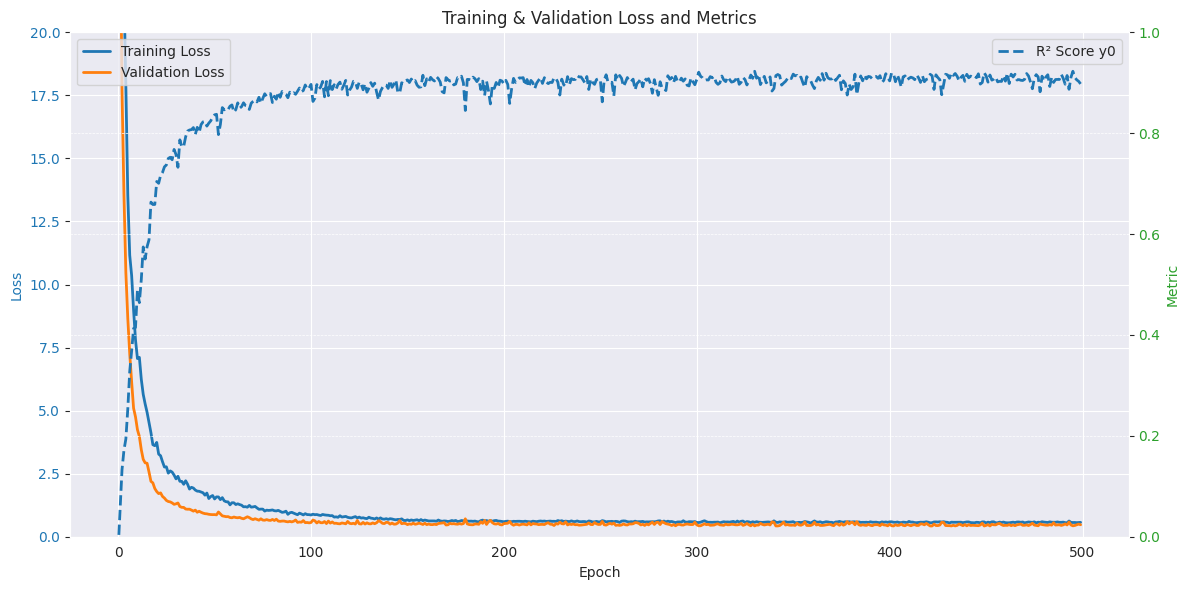

[0.38477883 0.31050714 0.24425412 ... 0.45169873 0.24736684 0.37766322]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 71.0367 | Val Loss: 9.0776 | Val Mean Metrics: 0.0307
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 8.9880 | Val Loss: 3.8434 | Val Mean Metrics: 0.4395
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 5.2531 | Val Loss: 2.5465 | Val Mean Metrics: 0.5767
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 3.8131 | Val Loss: 2.0021 | Val Mean Metrics: 0.6589
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 2.7588 | Val Loss: 1.6736 | Val Mean Metrics: 0.6963
Model saved at epoch 4 to /

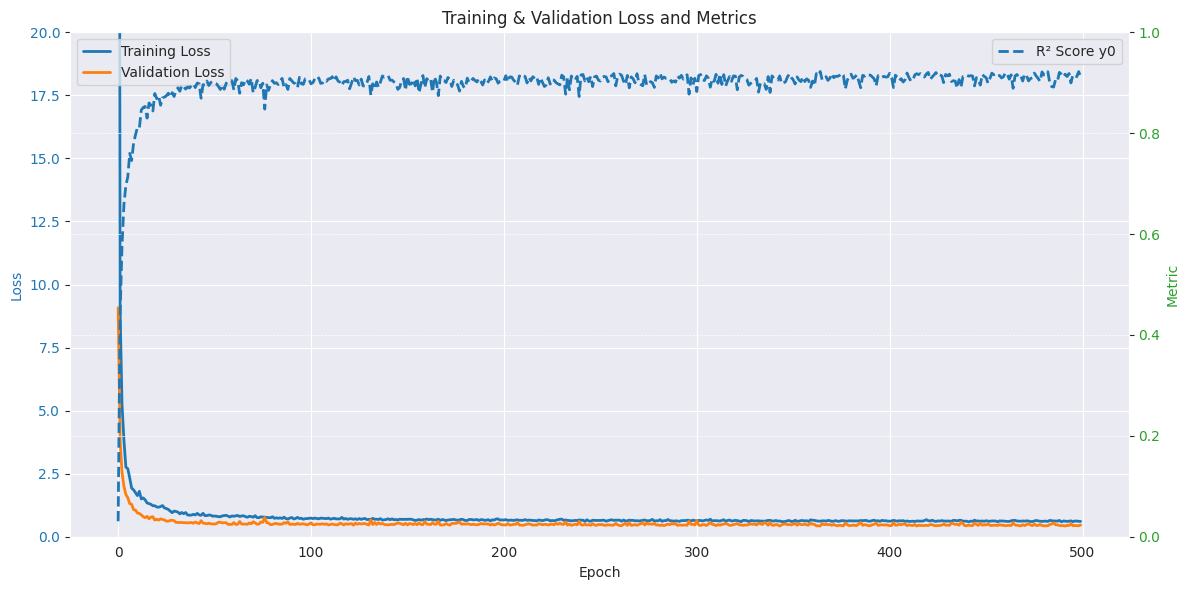

[0.34044208 0.36840161 0.43667196 ... 0.475612   0.3164587  0.35795591]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 28.4956 | Val Loss: 5.8244 | Val Mean Metrics: 0.3895
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 8.0429 | Val Loss: 3.1846 | Val Mean Metrics: 0.5678
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 5.9266 | Val Loss: 2.2349 | Val Mean Metrics: 0.6499
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 4.5699 | Val Loss: 1.8137 | Val Mean Metrics: 0.7122
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 3.4952 | Val Loss: 1.4615 | Val Mean Metrics: 0.7345
Model saved at epoch 4 to /

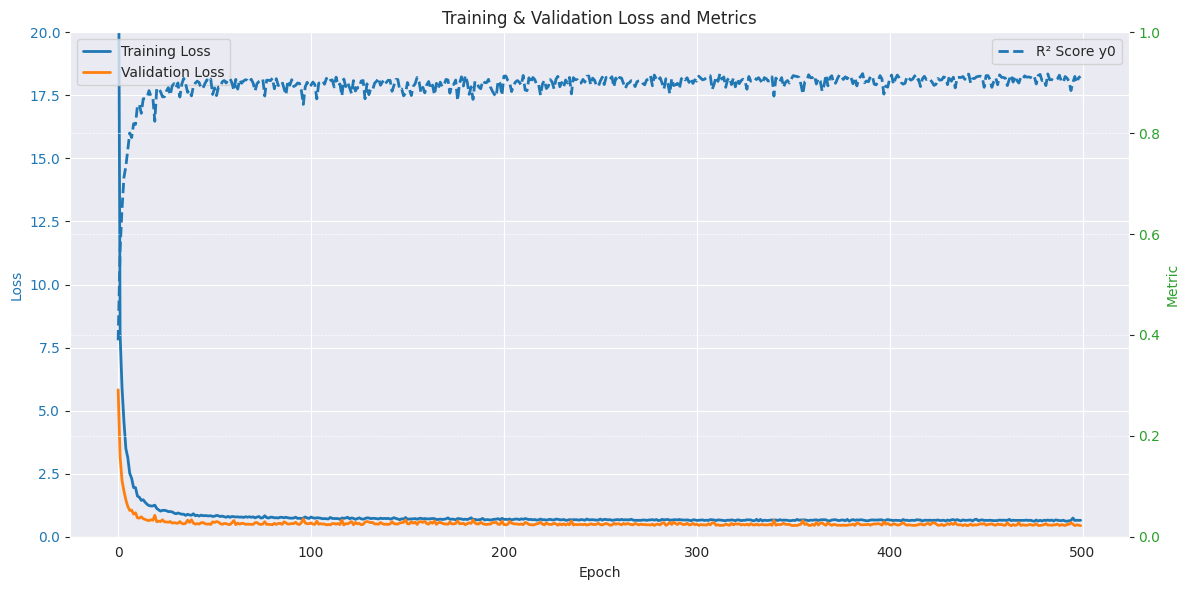

[0.47257229 0.39956188 0.45117957 ... 0.4719582  0.38242498 0.5842352 ]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 42.6983 | Val Loss: 4.5053 | Val Mean Metrics: 0.3963
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 7.1281 | Val Loss: 2.4422 | Val Mean Metrics: 0.6269
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 5.1557 | Val Loss: 1.7922 | Val Mean Metrics: 0.6948
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 3.9911 | Val Loss: 1.3714 | Val Mean Metrics: 0.7614
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 3.2889 | Val Loss: 1.1670 | Val Mean Metrics: 0.7671
Model saved at epoch 4 to /

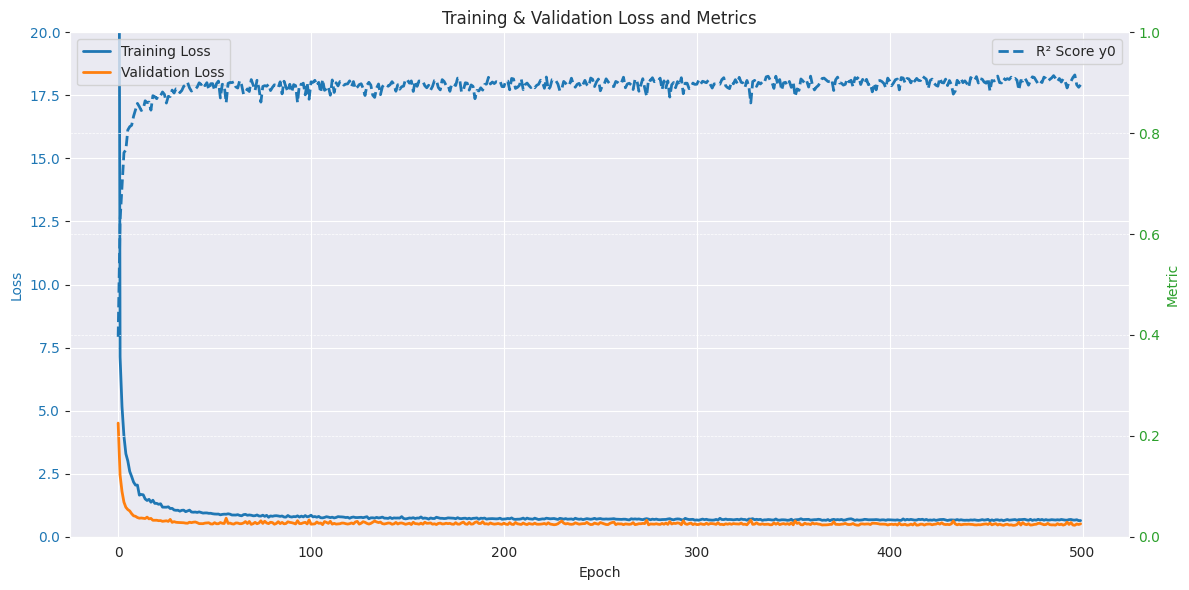

[0.45680659 0.35723974 0.37619931 ... 0.50097665 0.4035564  0.49504769]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 43.9110 | Val Loss: 7.8560 | Val Mean Metrics: 0.2883
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 9.8010 | Val Loss: 4.3768 | Val Mean Metrics: 0.4794
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 6.3943 | Val Loss: 2.8855 | Val Mean Metrics: 0.6221
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 4.9257 | Val Loss: 2.3050 | Val Mean Metrics: 0.6333
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 3.9293 | Val Loss: 1.8564 | Val Mean Metrics: 0.6873
Model saved at epoch 4 to /

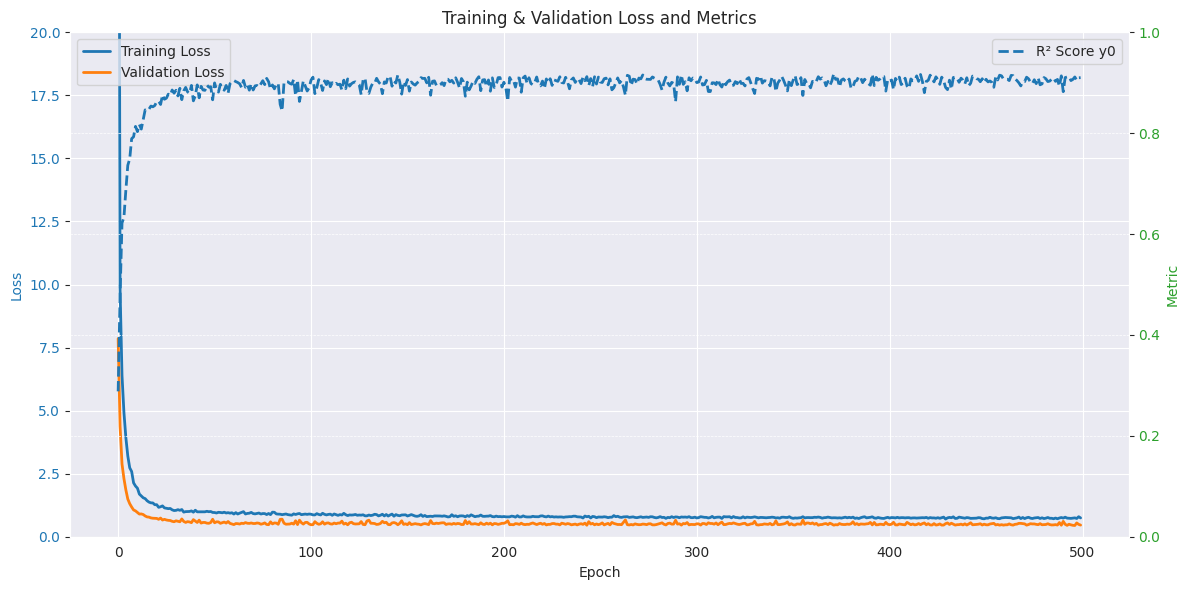

[0.4006092  0.38865549 0.31295712 ... 0.60771707 0.2965351  0.59043759]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 46.2307 | Val Loss: 7.7285 | Val Mean Metrics: 0.2216
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 10.5368 | Val Loss: 3.9641 | Val Mean Metrics: 0.4720
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 7.5414 | Val Loss: 3.0908 | Val Mean Metrics: 0.4748
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 5.5000 | Val Loss: 2.2354 | Val Mean Metrics: 0.6101
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 4.8082 | Val Loss: 1.9014 | Val Mean Metrics: 0.6534
Model saved at epoch 4 to 

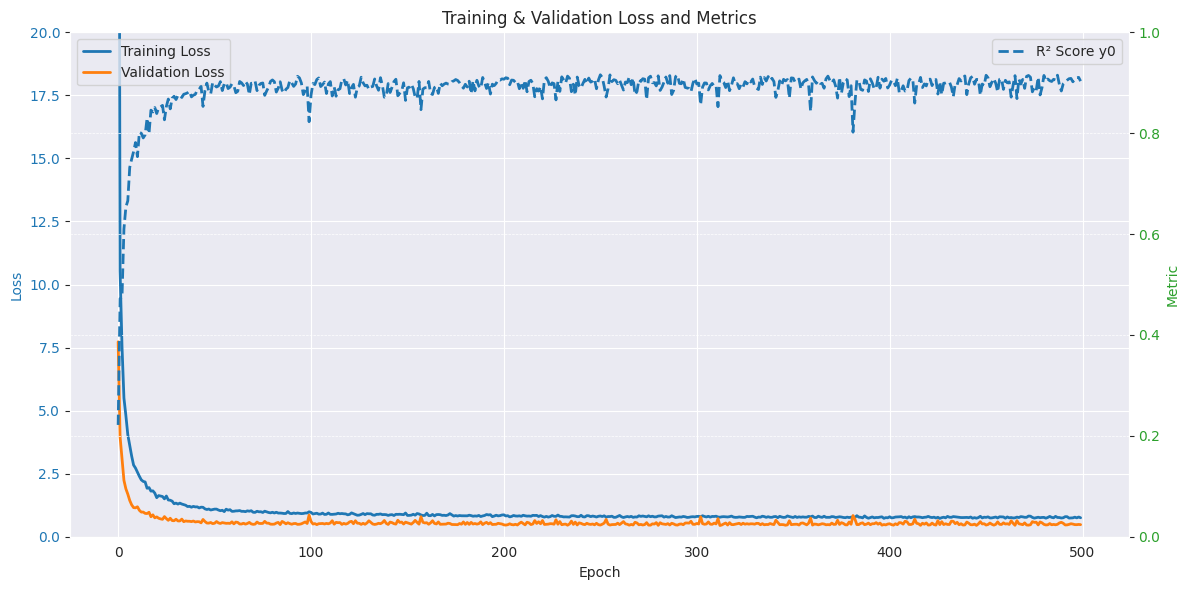

[0.59948031 0.43410846 0.4407337  ... 0.71019095 0.40061648 0.64980026]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 31.0520 | Val Loss: 4.4409 | Val Mean Metrics: 0.3901
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 6.2627 | Val Loss: 2.3986 | Val Mean Metrics: 0.5632
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 4.4649 | Val Loss: 1.6217 | Val Mean Metrics: 0.7068
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 3.7584 | Val Loss: 1.4762 | Val Mean Metrics: 0.7218
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 3.1681 | Val Loss: 1.1578 | Val Mean Metrics: 0.7757
Model saved at epoch 4 to /

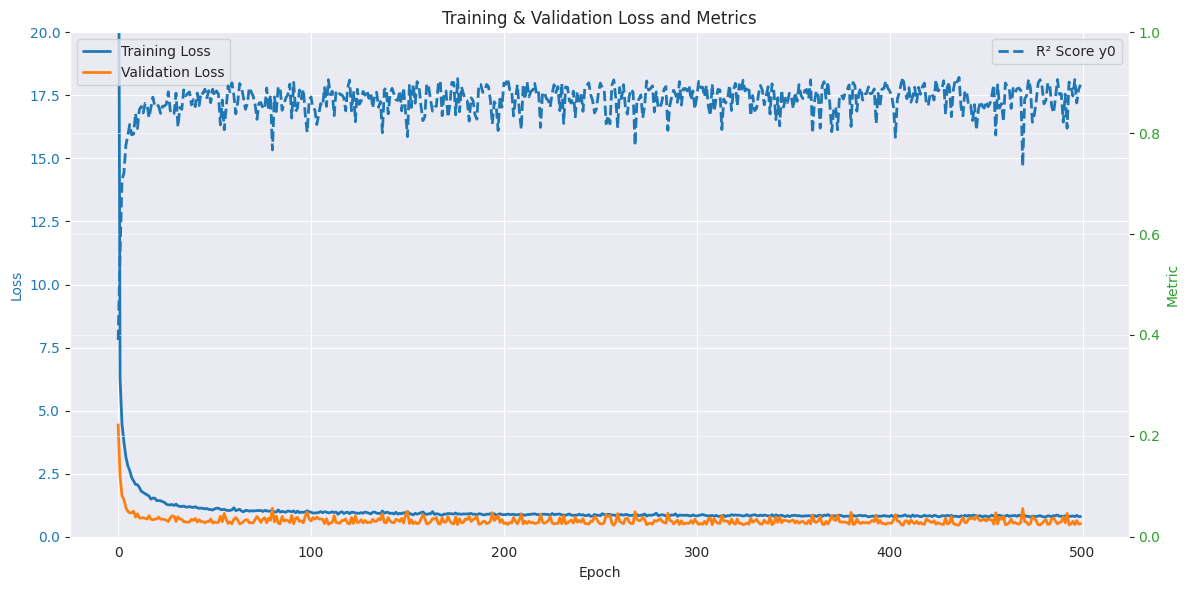

[0.61029326 0.51627804 0.52256504 ... 0.82967766 0.38146928 0.58887417]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 95.0440 | Val Loss: 17.4170 | Val Mean Metrics: 0.0721
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 17.7175 | Val Loss: 7.9845 | Val Mean Metrics: 0.3276
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 11.4368 | Val Loss: 5.2373 | Val Mean Metrics: 0.4234
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 8.1579 | Val Loss: 3.6713 | Val Mean Metrics: 0.5363
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 6.4995 | Val Loss: 2.9330 | Val Mean Metrics: 0.5585
Model saved at epoch 4 t

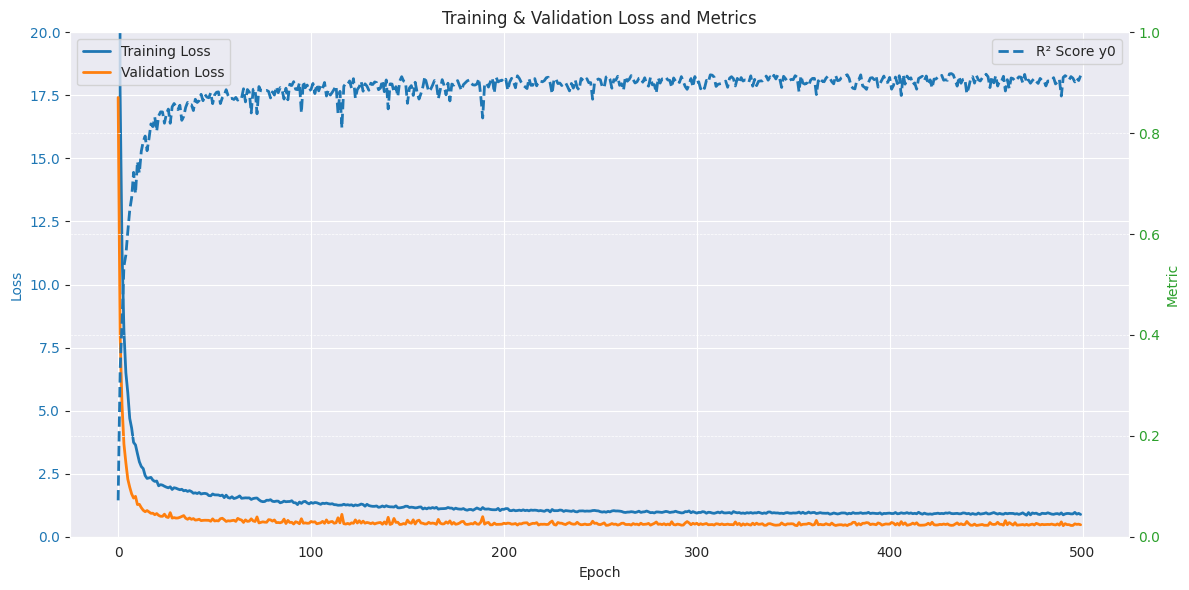

[0.5562419  0.54110032 0.53163853 ... 0.79456424 0.48527175 0.77083663]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 56.6448 | Val Loss: 4.3581 | Val Mean Metrics: 0.3666
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 11.4104 | Val Loss: 2.3405 | Val Mean Metrics: 0.5953
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 6.9207 | Val Loss: 1.7831 | Val Mean Metrics: 0.6236
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 5.4865 | Val Loss: 1.4263 | Val Mean Metrics: 0.7090
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 4.6981 | Val Loss: 1.2612 | Val Mean Metrics: 0.7120
Model saved at epoch 4 to 

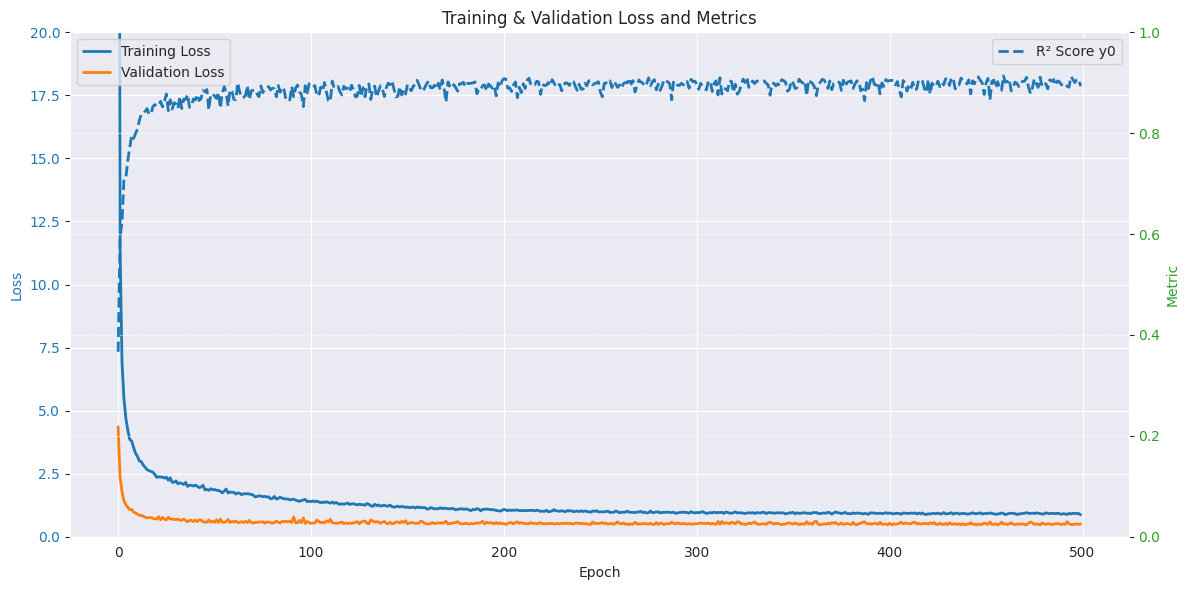

[0.53894326 0.46029919 0.41908812 ... 0.80042106 0.39554641 0.8011567 ]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 32.3699 | Val Loss: 3.2575 | Val Mean Metrics: 0.5690
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 11.7202 | Val Loss: 1.9164 | Val Mean Metrics: 0.6421
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 8.6454 | Val Loss: 1.3670 | Val Mean Metrics: 0.6736
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 6.4510 | Val Loss: 1.2710 | Val Mean Metrics: 0.6948
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 5.2088 | Val Loss: 0.9582 | Val Mean Metrics: 0.7868
Model saved at epoch 4 to 

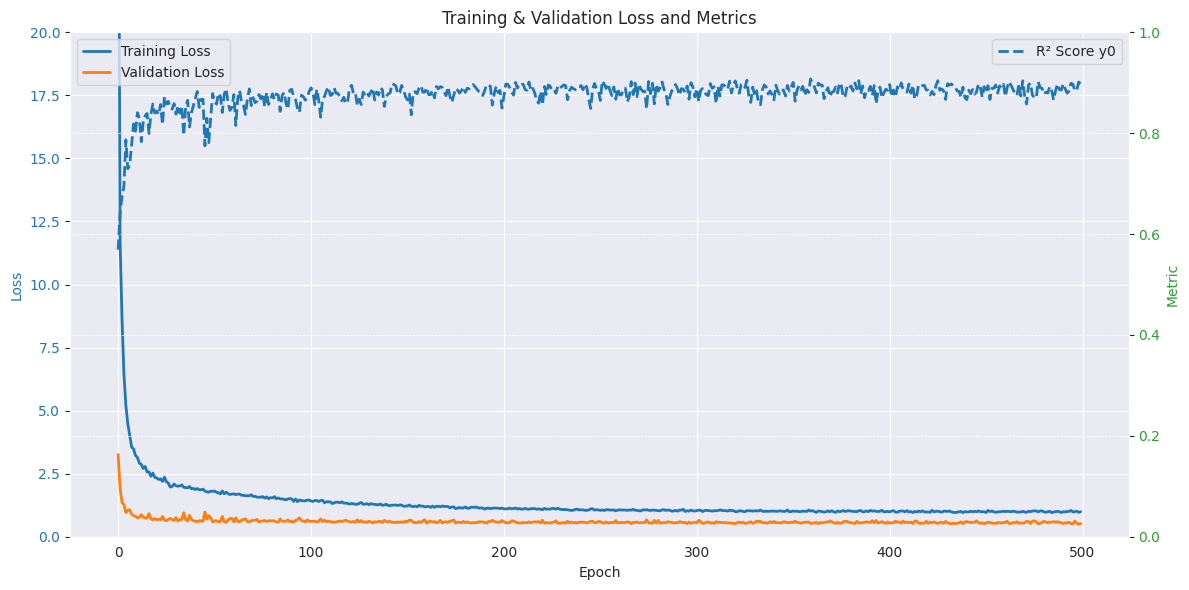

[0.60162869 0.53244579 0.46447289 ... 0.78508553 0.49335045 0.87183396]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 31.2529 | Val Loss: 2.9643 | Val Mean Metrics: 0.5552
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 8.6914 | Val Loss: 1.7676 | Val Mean Metrics: 0.6791
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 6.5198 | Val Loss: 1.7840 | Val Mean Metrics: 0.6462
Epoch 4/500 | Train Loss: 5.2392 | Val Loss: 1.6498 | Val Mean Metrics: 0.6206
Epoch 5/500 | Train Loss: 4.9030 | Val Loss: 1.1565 | Val Mean Metrics: 0.7726
Model saved at epoch 4 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 6/500 | Train Loss: 4.1747 | Val Loss: 1.0020 | Val Mean Metrics: 0.8037
Model saved at epoch 5 to /home/m

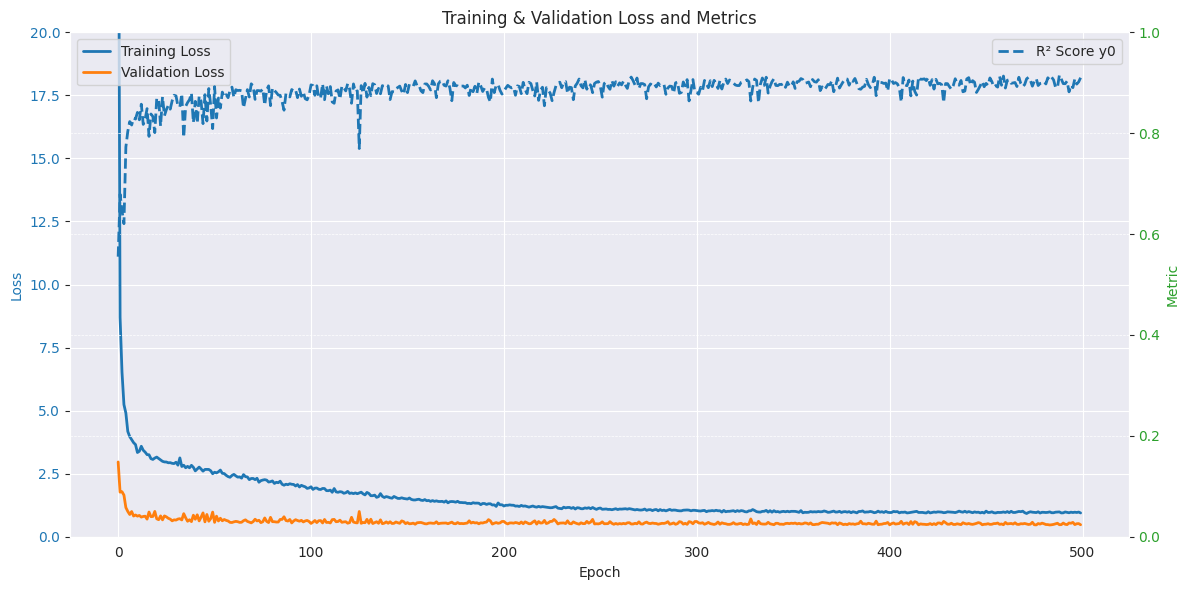

[0.58736851 0.52080609 0.4575734  ... 0.9148371  0.37743258 0.8039137 ]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 83.6548 | Val Loss: 10.3715 | Val Mean Metrics: 0.1837
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 18.9949 | Val Loss: 6.0713 | Val Mean Metrics: -0.0474
Epoch 3/500 | Train Loss: 13.2358 | Val Loss: 4.8501 | Val Mean Metrics: 0.0087
Epoch 4/500 | Train Loss: 10.3357 | Val Loss: 3.3616 | Val Mean Metrics: 0.3359
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 9.1740 | Val Loss: 2.9318 | Val Mean Metrics: 0.2657
Epoch 6/500 | Train Loss: 8.1790 | Val Loss: 2.2198 | Val Mean Metrics: 0.5151
Model saved at epoch 5 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 7/500 | Train Loss: 7.

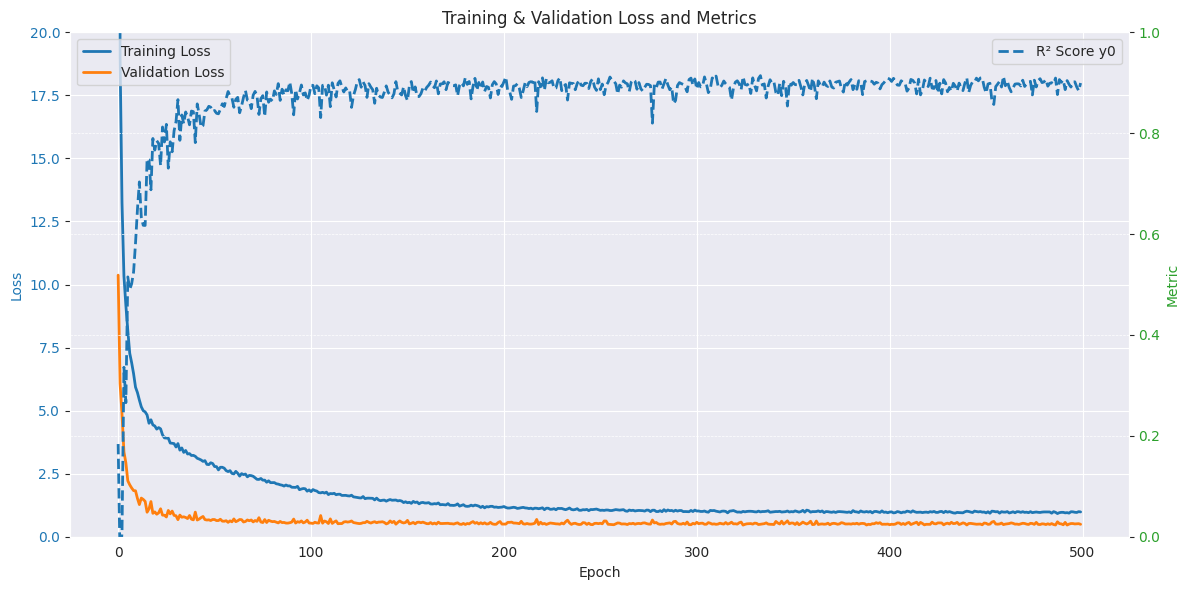

[0.55378073 0.5499115  0.44016191 ... 0.85643087 0.37502692 0.91355091]
Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 116.6439 | Val Loss: 20.8025 | Val Mean Metrics: -1.0080
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 30.3617 | Val Loss: 11.8928 | Val Mean Metrics: -0.5789
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 21.6567 | Val Loss: 10.7398 | Val Mean Metrics: -0.9142
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 18.3541 | Val Loss: 7.6643 | Val Mean Metrics: -0.6973
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 15.7666 | Val Loss: 6.5542 | Val Mean Metrics: -0.2917
Model saved at epoch 4 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 6/500 | 

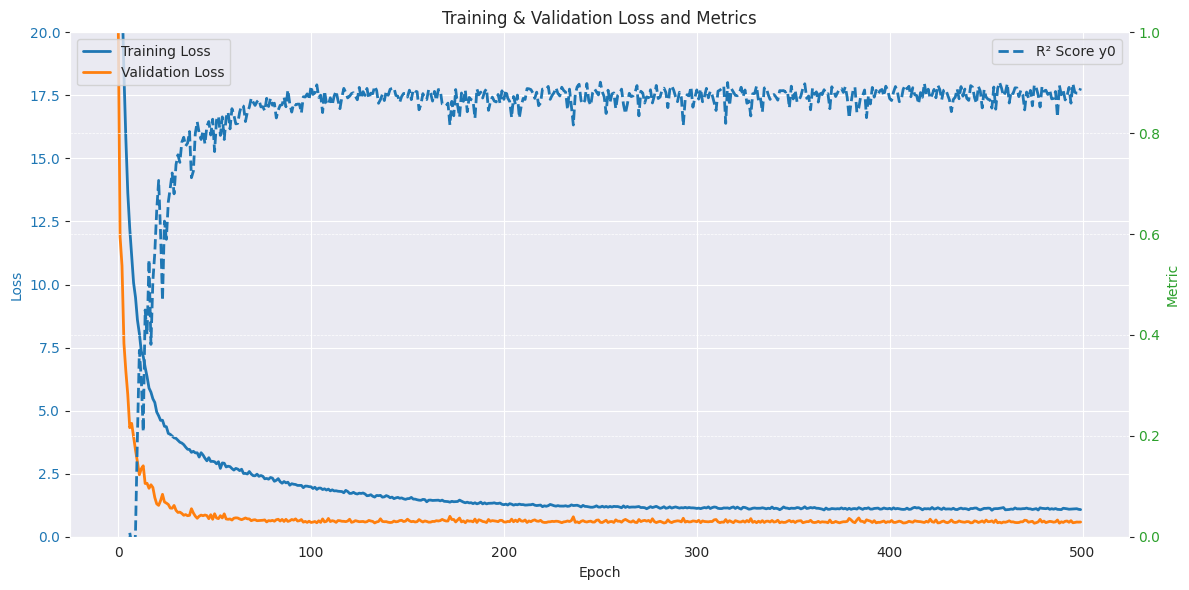

[0.56167221 0.58831458 0.59931449 ... 1.03312388 0.50306561 0.86204903]


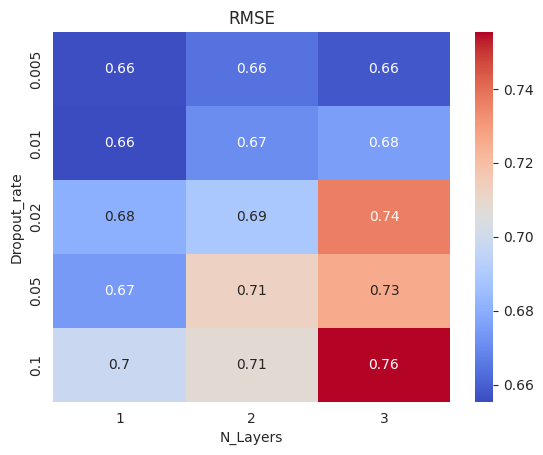

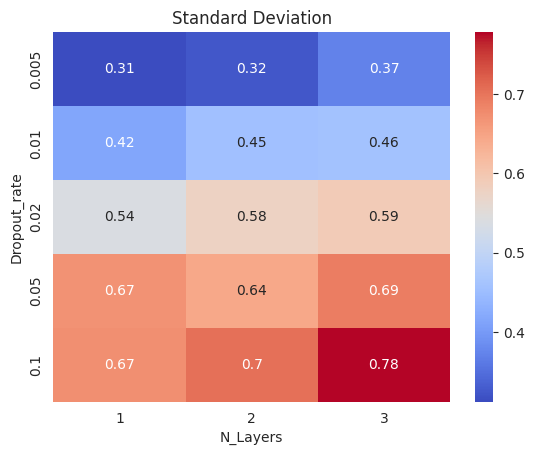

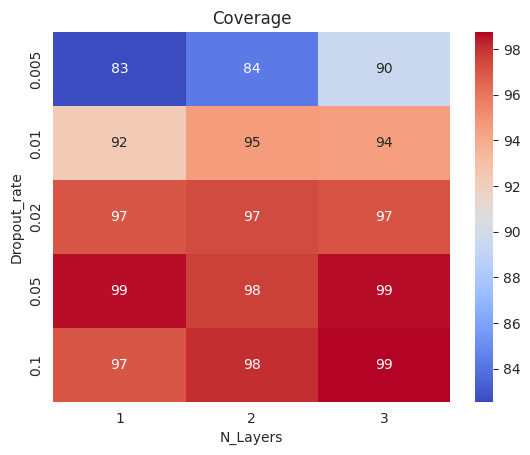

In [11]:

set_seed(42)
num_epochs = 500
LR = 0.002
N = 100
model_name = "CuiNetdp"
config = TrainerConfig(model_name=model_name)
config.update_config(batch_size=128,learning_rate=0.002 ,num_epochs=500,save_model=True,classification=False,max_loss_plot=20)

# Hyperparamètres à tester pour CuiNet
dropout_probs = [0.005, 0.01, 0.02, 0.05, 0.1]  # Probabilité de dropout (p)
dp_lay_values = [1, 2, 3]  # Nombre de couches de dropout

# Initialisation des matrices pour stocker les résultats
mean_rmse = np.zeros((len(dropout_probs), len(dp_lay_values)))  # Pour le RMSE
mean_std = np.zeros((len(dropout_probs), len(dp_lay_values)))  # Pour l'incertitude (écart-type)
mean_coverage = np.zeros((len(dropout_probs), len(dp_lay_values)))

list_of_models = []

for i, dp in enumerate(dropout_probs):
    for j, dp_lay in enumerate(dp_lay_values):
        # Initialisation du modèle CuiNet
        model = CuiNet_dp(mean=mean, std=std, out_dims=1, input_dims=x_cal.shape[1], dropout=dp,dp_lay=dp_lay)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=.015)
        criterion = torch.nn.MSELoss(reduction='mean')

        trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)

        # Initialisation de l'optimiseur et du critère

        train_losses, val_losses, val_r2_scores, final_path = trainer.train()
        model.load_state_dict(torch.load(final_path))
        # Évaluation des performances sur le jeu de test
        predictions = np.zeros((len(val_loader.dataset), N))  # Stockage des prédictions
        targets = np.zeros((len(val_loader.dataset), 1))
        model.train()

        for k in range(N):
            model.to("cuda")
            model.train()
            idx = 0
            for input, target in val_loader:
                input = input.cuda(non_blocking=True)
                target = target.float()
                with torch.no_grad():
                    output = model(input[:, None])
                    predictions[idx: idx + input.size(0), k] = output.cpu().numpy().squeeze()
                targets[idx: idx + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
                idx += input.size(0)

        # Calcul du RMSE
        list_of_models.append(copy.deepcopy(model))

        mean_predictions = predictions.mean(axis=1)

        uncertainties = predictions.std(axis=1)
        print(uncertainties)
        rmse_finale = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
        # Score Z pour un intervalle de confiance à 95%
        # Calcul des intervalles de confiance (prédiction ± incertitude)
        lower_bound = mean_predictions - 3 * uncertainties
        upper_bound = mean_predictions + 3 * uncertainties

        # Vérification si la vraie valeur est à l'intérieur de l'intervalle
        covered = (targets[:, 0] >= lower_bound) & (targets[:, 0] <= upper_bound)
        # Calcul de la couverture
        coverage = covered.mean() * 100

        # Stockage des résultats
        mean_rmse[i, j] = rmse_finale
        mean_std[i, j] = uncertainties.mean()
        mean_coverage[i, j] = coverage

plt.figure(facecolor="white")
# Heatmap pour le RMSE moyen
sns.heatmap(mean_rmse, annot=True, xticklabels=dp_lay_values, yticklabels=dropout_probs, cmap="coolwarm")
plt.title("RMSE")
plt.ylabel("Dropout_rate")
plt.xlabel("N_Layers")
plt.savefig("figure/dp/heatmap_rmse.pdf",dpi=500)
plt.show()

plt.figure(facecolor="white")
# Heatmap pour l'écart-type moyen
sns.heatmap(mean_std, annot=True, xticklabels=dp_lay_values, yticklabels=dropout_probs, cmap="coolwarm")
plt.title("Standard Deviation")
plt.ylabel("Dropout_rate")
plt.xlabel("N_Layers")
plt.savefig("figure/dp/heatmap_std.pdf",dpi=500)
plt.show()
plt.figure(facecolor="white")
# Heatmap pour l'écart-type moyen
sns.heatmap(mean_coverage, annot=True, xticklabels=dp_lay_values, yticklabels=dropout_probs, cmap="coolwarm")
plt.title("Coverage")
plt.ylabel("Dropout_rate")
plt.xlabel("N_Layers")
plt.savefig("figure/dp/heatmap_coverage.pdf",dpi=500)
plt.show()



Saving best model to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 1/500 | Train Loss: 74.6588 | Val Loss: 6.4915 | Val Mean Metrics: 0.4082
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Model saved at epoch 0 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 2/500 | Train Loss: 7.2476 | Val Loss: 3.4606 | Val Mean Metrics: 0.5434
Model saved at epoch 1 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 3/500 | Train Loss: 5.9642 | Val Loss: 2.5830 | Val Mean Metrics: 0.6169
Model saved at epoch 2 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 4/500 | Train Loss: 4.4153 | Val Loss: 2.1148 | Val Mean Metrics: 0.6797
Model saved at epoch 3 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 5/500 | Train Loss: 3.7633 | Val Loss: 1.9025 | Val Mean Metrics: 0.7090
Model saved at epoch 4 to /home/metz/deepchemometrics/Aioly/models/CuiNetdp_best.pth
Epoch 6/500 | 

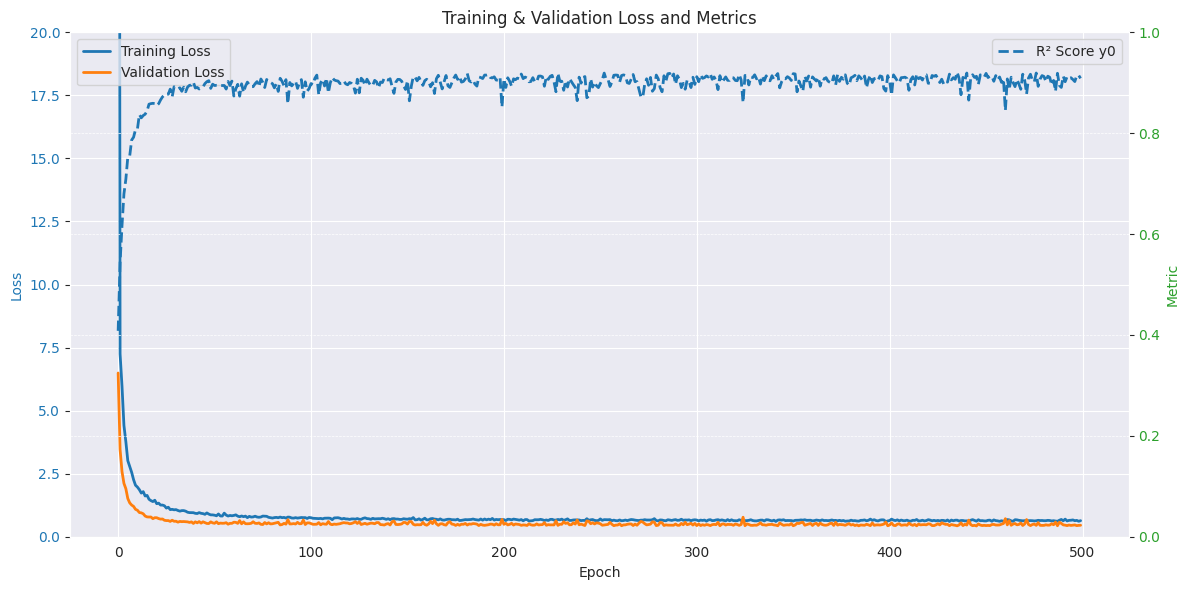

Coverage (95% interval): 88.12%


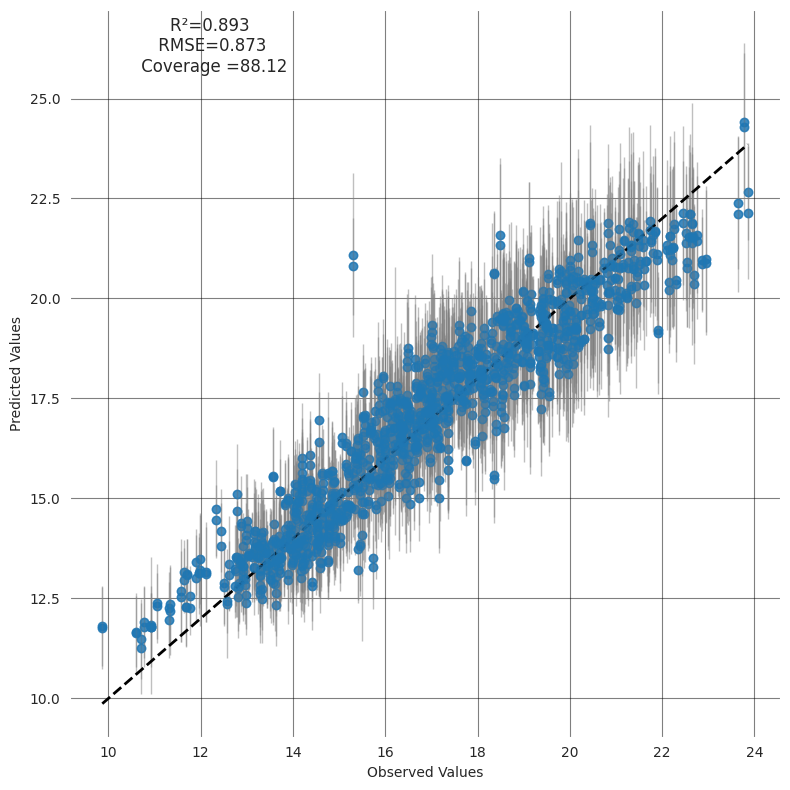

In [12]:
# Hyperparamètres à tester pour CuiNet
dropout_probs = [ 0.01]  # Probabilité de dropout (p)
dp_lay_values = [2]  # Nombre de couches de dropout

# Initialisation des matrices pour stocker les résultats
mean_rmse = np.zeros((len(dropout_probs), len(dp_lay_values)))  # Pour le RMSE
mean_std = np.zeros((len(dropout_probs), len(dp_lay_values)))  # Pour l'incertitude (écart-type)
mean_coverage = np.zeros((len(dropout_probs), len(dp_lay_values)))

list_of_models = []

for i, dp in enumerate(dropout_probs):
    for j, dp_lay in enumerate(dp_lay_values):
        # Initialisation du modèle CuiNet
        model = CuiNet_dp(mean=mean, std=std, out_dims=1, input_dims=x_cal.shape[1], dropout=dp,dp_lay=dp_lay)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=.015)
        criterion = torch.nn.MSELoss(reduction='mean')

        trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, train_loader=cal_loader, val_loader=val_loader, config=config)

        # Initialisation de l'optimiseur et du critère

        train_losses, val_losses, val_r2_scores, final_path = trainer.train()
        model.load_state_dict(torch.load(final_path))
        # Évaluation des performances sur le jeu de test
        predictions = np.zeros((len(test_loader.dataset), N))  # Stockage des prédictions
        targets = np.zeros((len(test_loader.dataset), 1))
        model.train()

        for k in range(N):
            model.to("cuda")
            model.train()
            idx = 0
            for input, target in test_loader:
                input = input.cuda(non_blocking=True)
                target = target.float()
                with torch.no_grad():
                    output = model(input[:, None])
                    predictions[idx: idx + input.size(0), k] = output.cpu().numpy().squeeze()
                targets[idx: idx + target.size(0)] = target.cpu().numpy().reshape(-1, 1)
                idx += input.size(0)

# Calcul du RMSE
list_of_models.append(copy.deepcopy(model))

# Calcul des métriques
mean_predictions = predictions.mean(axis=1)
uncertainties = predictions.std(axis=1)
rmse_finale = np.sqrt(np.mean((mean_predictions - targets.squeeze()) ** 2))
r2 = r2_score(targets.squeeze(), mean_predictions)


# Score Z pour un intervalle de confiance à 95%
# Calcul des intervalles de confiance (prédiction ± incertitude)
lower_bound = mean_predictions - 3 * uncertainties
upper_bound = mean_predictions + 3 * uncertainties

# Vérification si la vraie valeur est à l'intérieur de l'intervalle
covered = (targets[:, 0] >= lower_bound) & (targets[:, 0] <= upper_bound)

# Calcul de la couverture
coverage = covered.mean()

# Affichage de la couverture en pourcentage
print(f"Coverage (95% interval): {coverage * 100:.2f}%")
# Visualisation : Scatter plot pour le meilleur RMSE moyen
fig, ax = plt.subplots(figsize=(8, 8))  # <-- changement ici pour récupérer fig, ax

# Scatter plot
ax.scatter(targets, mean_predictions, alpha=0.7)

# Texte (R², RMSE, Coverage)
ax.text(0.2, 0.95, f"R²={r2:.3f} \n RMSE={rmse_finale:.3f} \n Coverage ={coverage * 100:.2f}",
         ha='center', va='center', fontsize=12, transform=ax.transAxes)

# Barres d'erreur
ax.errorbar(
    targets.squeeze(),
    mean_predictions,
    yerr=uncertainties * 3,
    fmt='o',
    ecolor='gray',
    elinewidth=1,
    alpha=0.5,
    label="Uncertainty"
)

# Ligne y=x
ax.plot(
    [targets.min(), targets.max()],
    [targets.min(), targets.max()],
    'k--', lw=2,
    label="Perfect Prediction (y=x)"
)

# Labels
ax.set_xlabel("Observed Values")
ax.set_ylabel("Predicted Values")

# Grille noire
ax.grid(color='black', alpha=0.5)

# Fond du graphe en blanc
ax.set_facecolor('white')

# Fond de la figure en blanc
fig.patch.set_facecolor('white')

# Ajustement automatique
plt.tight_layout()

plt.savefig("figure/dp/best_model.pdf",dpi = 500)
plt.show()
